In [3]:
import pandas as pd
import altair as alt
import sys
sys.path.append('../')
from mod import load_data, alt_theme

In [4]:
renderer = "jupyterlab"

In [5]:
comments, issues, prs = load_data('../../data/')
bot_names = pd.read_csv('../bot_names.csv')
comments = comments.query('author not in @bot_names')
issues = issues.query('author not in @bot_names')
prs = prs.query('author not in @bot_names')

In [6]:
alt.renderers.enable(renderer);
alt.themes.register('my_theme', alt_theme)
alt.themes.enable("my_theme")

ThemeRegistry.enable('my_theme')

In [35]:
author_prs = (
    prs.groupby(['org', 'repo', 'author'])
    .agg({'id': 'count'})
    .rename(columns={'id': 'count'})
    .sort_values(['org', 'repo', 'count'], ascending=False)
)

In [36]:
pony_factors = []
top_authors_all = []
for (org, repo), idata in author_prs.groupby(['org', 'repo']):
    idata = idata.reset_index()
    total_prs = idata['count'].sum()  
    top_authors = idata.groupby('author').sum()['count'].sort_values(ascending=False).to_frame()
    top_authors['org'] = org
    top_cumulative = top_authors['count'].cumsum()
    top_half = top_cumulative > (total_prs / 2)
    pony_factor = (~top_half).sum() + 1
    pony_factors.append((org, repo, pony_factor))
    top_authors_all.append(top_authors.head(20))
pony_factors = pd.DataFrame(pony_factors, columns=['org', 'repo', 'pony'])
top_authors = pd.concat(top_authors_all)

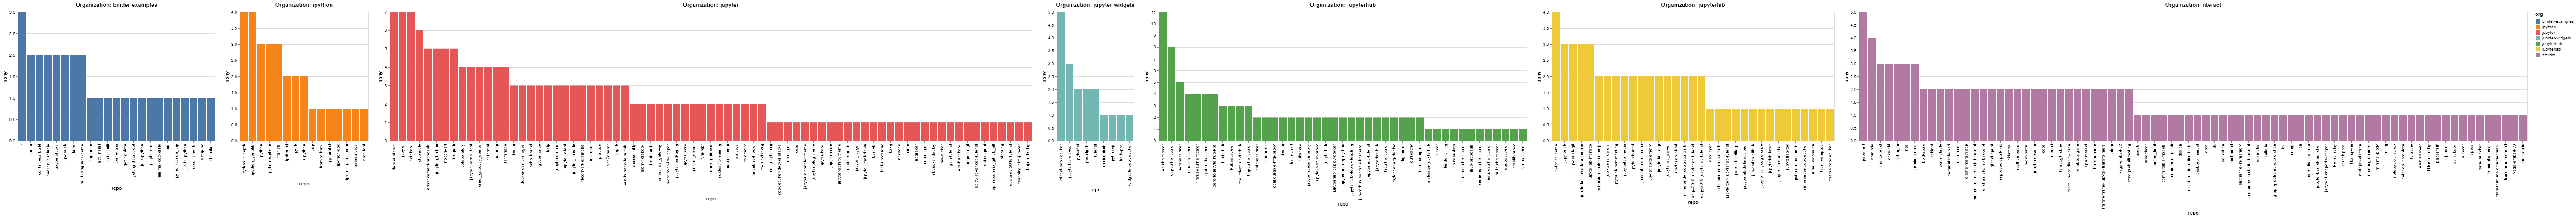

In [30]:
charts = []
for iorg, idata in pony_factors.groupby('org'):
    idata = idata.sort_values(['org', 'pony'], ascending=False)
    ch = alt.Chart(idata, title=f'Organization: {iorg}').mark_bar().encode(
        x=alt.X('repo', sort=idata['repo'].tolist()),
        y='pony',
        color='org'
    )
    charts.append(ch)
alt.hconcat(*charts)

In [31]:
prs['createdAt'] = pd.to_datetime(prs['createdAt'])
author_count_by_month = (
    prs.groupby(['org', 'author'])
    .resample('30D', on='createdAt')
    .agg({'id': 'count'})
    .rename(columns={'id': 'count'})
)

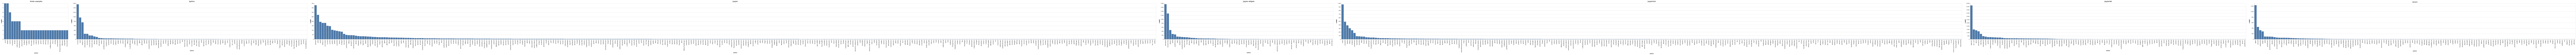

In [32]:
charts = []
for org, iauthors in top_authors.groupby('org'):
    author_order = iauthors.sort_values(['count'], ascending=False).index.values.tolist()
    ch = alt.Chart(iauthors.reset_index(), title=org).mark_bar().encode(
        x=alt.X('author', sort=author_order),
        y='count',
    )
    charts.append(ch)
alt.hconcat(*charts)

In [ ]:
%%html
<script src="https://cdn.rawgit.com/parente/4c3e6936d0d7a46fd071/raw/65b816fb9bdd3c28b4ddf3af602bfd6015486383/code_toggle.js"></script>